### This script is used to check BP for DCM-RNN
- Keep the majority parameters "correct".
- Calculate the loss as a function of remaining parameter.
- Check whether BP can find the targeted optimal point.

In [2]:
import importlib
import numpy as np
import scipy as sp
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.mlab as mlab
from mpl_toolkits.mplot3d import axes3d
import math as mth
from tensorflow.python.framework import ops
from IPython.display import clear_output
from scipy.interpolate import interp1d
import os, shutil
import pandas as pd
from tensorflow.python.client import timeline
import statistics 
from pylab import savefig

ImportError: No module named tensorflow

In [9]:
import CBI
import population
importlib.reload(CBI)
importlib.reload(population)

<module 'population' from '/Users/yuanwang/Google_Drive/projects/Gits/DCM-RNN/population.py'>

In [10]:
global_settings = type('container', (object,), {})()
global_settings.t_delta = 0.25
global_settings.n_stimuli = 1
global_settings.n_recurrent_step = 12

###  Create a subject

In [138]:
flags=type('container', (object,), {})()
flags.random_hemodynamic_parameter = True
flags.random_h_state_initial = True
flags.random_x_state_initial = True

s=population.get_a_subject(flags=flags)
m=CBI.configure_a_scanner(t_delta=global_settings.t_delta,n_stimuli=global_settings.n_stimuli)
u,y,y_noised,x,h=m.quick_scan(s,return_x=True,return_h=True)

#parameter_true=s.show_all_variable_value(True)

In [139]:
#y_noised=m.add_noise(y,2)

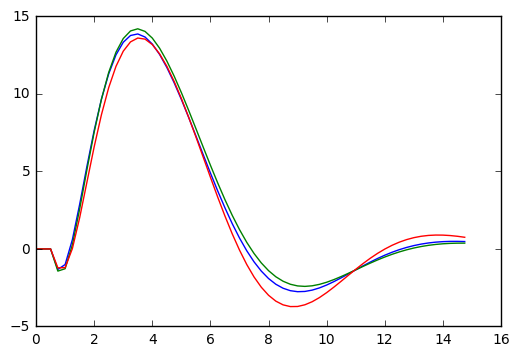

In [140]:
h_impulse_response = m.h_impulse_response(s)
plt.plot(np.arange(int(h_impulse_response.shape[-1]))*m.t_delta,h_impulse_response[:,0,:].transpose())

In [141]:
s.hemodynamic_parameters

,alpha,E0,k,gamma,tao,epsilon,V0,TE,r0,theta0
region_0,0.297512,0.316932,0.692635,0.413096,0.948192,0.4,100.0,0.03,25,40.3
region_1,0.313804,0.354622,0.723287,0.409610,0.952512,0.4,100.0,0.03,25,40.3
region_2,0.306641,0.312019,0.626602,0.438645,1.017214,0.4,100.0,0.03,25,40.3


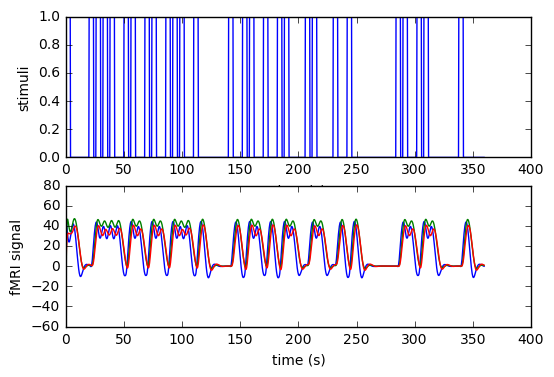

In [142]:
plt.subplot(211)
plt.plot(np.arange(m.n_time_point)*m.t_delta,u.transpose())
plt.xlabel('time (s)')
plt.ylabel('stimuli')
plt.subplot(212)
plt.plot(np.arange(m.n_time_point)*m.t_delta,y[:,0,:].transpose())
plt.xlabel('time (s)')
plt.ylabel('fMRI signal')

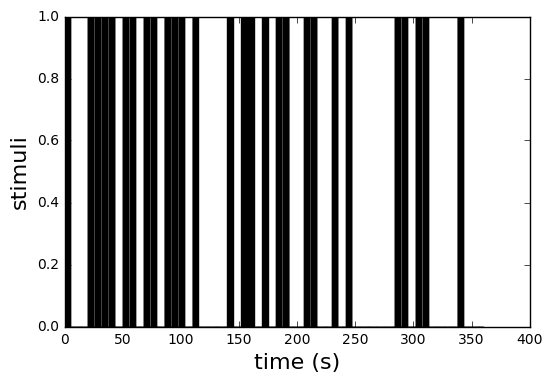

In [143]:
plt.bar(np.arange(m.n_time_point)*m.t_delta,u.transpose())
plt.xlabel('time (s)',fontsize=16)
plt.ylabel('stimuli',fontsize=16)

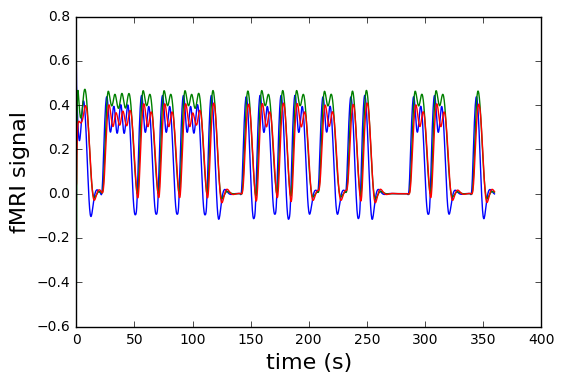

In [144]:
plt.plot(np.arange(m.n_time_point)*m.t_delta,y[:,0,:].transpose()/100)
plt.xlabel('time (s)',fontsize=16)
plt.ylabel('fMRI signal',fontsize=16)

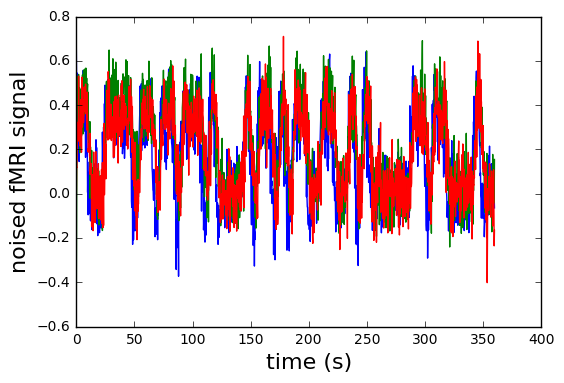

In [145]:
plt.plot(np.arange(m.n_time_point)*m.t_delta,y_noised[:,0,:].transpose()/100)
plt.xlabel('time (s)',fontsize=16)
plt.ylabel('noised fMRI signal',fontsize=16)

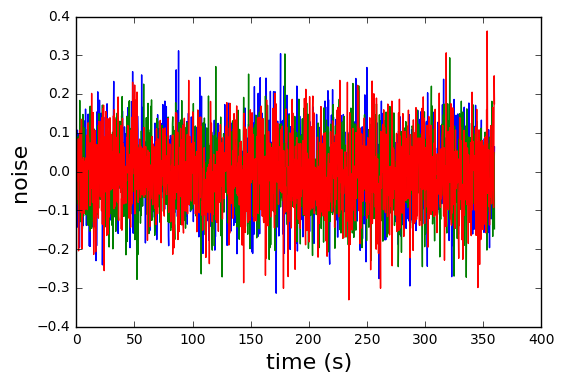

In [146]:
plt.plot(np.arange(m.n_time_point)*m.t_delta,y[:,0,:].transpose()/100-y_noised[:,0,:].transpose()/100)
plt.xlabel('time (s)',fontsize=16)
plt.ylabel('noise',fontsize=16)

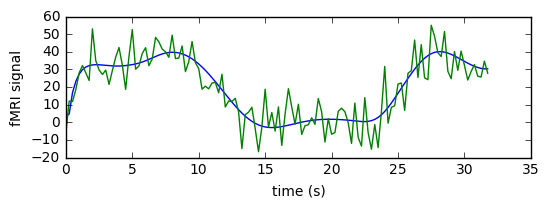

In [147]:
n_shown = 128
i_region = 2
plt.subplot(211)
plt.plot(np.arange(n_shown)*m.t_delta,y[i_region,0,:n_shown].transpose())
plt.xlabel('time (s)')
plt.ylabel('fMRI signal')
plt.subplot(211)
plt.plot(np.arange(n_shown)*m.t_delta,y_noised[i_region,0,:n_shown].transpose())
plt.xlabel('time (s)')
plt.ylabel('fMRI signal')

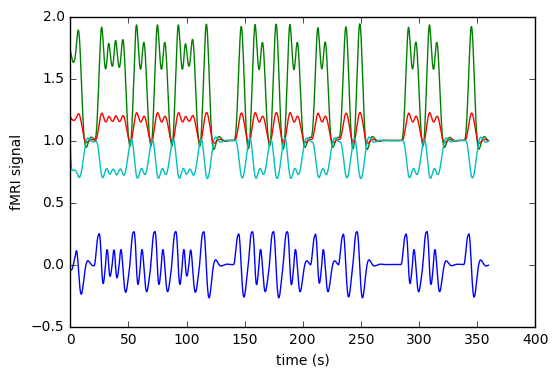

In [148]:
# plot it to check hemodynamic states to ensure they are in proper range
plt.plot(np.arange(m.n_time_point)*m.t_delta,h[2,:,:].transpose())
#plt.plot(np.arange(250,350),h[0,:,250:350].transpose())
plt.xlabel('time (s)')
plt.ylabel('fMRI signal')

### Data preparation

In [149]:
import data_helper
importlib.reload(data_helper)

<module 'data_helper' from '/Users/yuanwang/Google_Drive/projects/Gits/DCM-RNN/data_helper.py'>

In [150]:
# target u: [m.n_stimuli, n_recurrent_step]
# target x: [m.n_region, n_recurrent_step]
n_recurrent_step=global_settings.n_recurrent_step

dh=data_helper.get_a_data_helper()
dh.u=u[:]
dh.x=x[:]
dh.y=y[:]
dh.y_noised=y_noised[:]

dh.u_list=dh.cut2shape(dh.u,[m.n_stimuli, n_recurrent_step],n_recurrence=n_recurrent_step)
dh.x_list=dh.cut2shape(dh.x,[m.n_region, n_recurrent_step],n_recurrence=n_recurrent_step)
dh.y_list=dh.cut2shape(dh.y,[m.n_region, n_recurrent_step],n_recurrence=n_recurrent_step)
dh.y_noised_list=dh.cut2shape(dh.y_noised,[m.n_region, n_recurrent_step],n_recurrence=n_recurrent_step)
print('u_list has '+str(len(dh.u_list))+' segments, each of size '+str(dh.u_list[0].shape))
print('x_list has '+str(len(dh.x_list))+' segments, each of size '+str(dh.x_list[0].shape))
print('y_list has '+str(len(dh.y_list))+' segments, each of size '+str(dh.y_list[0].shape))
print('y_noised_list has '+str(len(dh.y_noised_list))+' segments, each of size '+str(dh.y_noised_list[0].shape))

u_list has 120 segments, each of size (1, 12)
x_list has 120 segments, each of size (3, 12)
y_list has 120 segments, each of size (3, 12)
y_noised_list has 120 segments, each of size (3, 12)


### Build model

In [151]:
ops.reset_default_graph()
import DCM_RNN
importlib.reload(DCM_RNN)
global_settings.learning_rate=0.00001
dr=DCM_RNN.DCM_RNN(m,n_recurrent_step=global_settings.n_recurrent_step,learning_rate=global_settings.learning_rate)
# configure the model
dr.hyperparameter_values[dr.variable_scope_name_x]['sparse']=0.8
dr.hyperparameter_values[dr.variable_scope_name_h]['prior']=5
dr.hyperparameter_values[dr.variable_scope_name_h]['gradient']=0.1
util=DCM_RNN.utilities()

In [152]:
# build a model 
dr.build_a_model()
#dr.parameter_profile

build_a_model: variables created.
build_a_model: layers created.
build_a_model: losses added.
build_a_model: finished.


In [153]:
# training summary
acc_Wxx=1-util.rMSE(dr.Wxx,s.Wxx)
acc_Wxxu=[1-util.rMSE(dr.Wxxu[n],s.Wxxu[n]) for n in range(dr.n_stimuli)]
acc_Wxxu=tf.add_n(acc_Wxxu)
acc_Wxu=1-util.rMSE(dr.Wxu,s.Wxu.reshape((m.n_region,1)))

loss_summary = tf.scalar_summary('fMRI_prediction_loss',dr.loss_y)
acc_Wxx_summary = tf.scalar_summary('acc_Wxx',acc_Wxx)
acc_Wxxu_summary = tf.scalar_summary('acc_Wxxu',acc_Wxxu)
acc_Wxu_summary = tf.scalar_summary('acc_Wxu',acc_Wxu)
opt_summary = tf.merge_summary([loss_summary, acc_Wxx_summary, acc_Wxxu_summary,acc_Wxu_summary])

summary_dir = os.path.abspath(os.path.join(os.path.curdir, "summary"))

# remove existing files
for the_file in os.listdir(summary_dir):
    file_path = os.path.join(summary_dir, the_file)
    try:
        if os.path.isfile(file_path):
            os.unlink(file_path)
        #elif os.path.isdir(file_path): shutil.rmtree(file_path)
    except Exception as e:
        print(e)

In [154]:
# open session and initilize
try:
    isess
except:
    isess = tf.InteractiveSession()
else:
    isess.close()
    isess = tf.InteractiveSession()

opt_init_all=tf.initialize_all_variables()
isess.run(opt_init_all)
# add summary
#summary_writer = tf.train.SummaryWriter(summary_dir, isess.graph)

### version 2, masks are written in the model

In [366]:
# test losses
# f=open('timeline.json', 'w')
loss_values_static=[]

current_value = 0.3
# set parameter value
Wxx=np.array([[-1,0,0],[0.8,-1,0.4],[0.4,0.8,-1]],dtype=np.float32)*dr.t_delta+np.eye(dr.n_region,dr.n_region,0,dtype=np.float32)
Wxxu=Wxxu=[np.array([[0,0,0],[0,0,0],[0,0,-0.4]],dtype=np.float32)*dr.t_delta for _ in range(dr.n_stimuli)]
Wxu=np.eye(dr.n_region,dr.n_stimuli,dtype=np.float32)*0.4*dr.t_delta 
Wxu[0]=current_value*dr.t_delta
dr.set_connection_matrices(isess, Wxx=Wxx, Wxxu=Wxxu, Wxu=Wxu)

n_epoch=1
for epoch in range(n_epoch):
    loss_y_sum=0.
    loss_sparse_sum=0.
    loss_prior_sum=0.
    x_feed=np.zeros((m.n_region,1),dtype=np.float32)
    h_feed=[np.array([0.,1.,1.,1.],dtype=np.float32).reshape(4,1) for _ in range(dr.n_region)]

    #for i in range(0,len(dh.u_list)):
    for i in range(1):
        feed_dict={i: d for i, d in zip(dr.h_state_initial, h_feed)}
        feed_dict[dr.x_state_initial]=x_feed
        feed_dict[dr.input_u]=dh.u_list[i]
        feed_dict[dr.input_y_true]=dh.y_list[i]
        #util.append_masks_to_feed_dict(dr,feed_dict,variable_dict)

        grads_and_vars,processed_grads_and_vars,x_feed,h_feed,loss_y,loss_sparse_list,loss_sparse,loss_prior_list,loss_prior\
                                            = isess.run([
                                            dr.grads_and_vars,
                                            dr.processed_grads_and_vars,
                                            #dr.apply_gradient,
                                            dr.x_state_final,
                                            dr.h_state_final,
                                            dr.loss_y,
                                            dr.loss_sparse_list,
                                            dr.loss_sparse,
                                            dr.loss_prior_list,
                                            dr.loss_prior], feed_dict=feed_dict)
        print("segment {:g}, loss_y {:g}, loss_sparse {:g}, loss_prior {:g} "\
              .format(i, loss_y,loss_sparse, loss_prior))
        loss_y_sum+=loss_y 
        loss_sparse_sum+=loss_sparse
        loss_prior_sum+=loss_prior
    loss_values_static.append(loss_sparse_sum)
    print("epoch {:g}, loss_y {:g}, loss_sparse {:g}, loss_prior {:g} "\
              .format(epoch, loss_y_sum,loss_sparse_sum, loss_prior_sum))

segment 0, loss_y 0.0824449, loss_sparse 2.42, loss_prior 0 
epoch 0, loss_y 0.0824449, loss_sparse 2.42, loss_prior 0 


In [367]:
importlib.reload(DCM_RNN)
util=DCM_RNN.utilities()
parameter_trained=util.show_all_variable_value(dr,isess,visFlag=False)
tmp=util.compare_parameters(parameter_trained,parameter_true,visFlag=True,parameter_list=['Wxx','Wxxu_s0','Wxu','hemodynamic_parameters'])

Wxx


set1                    set2                 difference          \
      From_r0 From_r1 From_r2 From_r0 From_r1 From_r2    From_r0 From_r1   
To_r0    0.75    0.00    0.00    0.75    0.00    0.00        0.0     0.0   
To_r1    0.20    0.75    0.10    0.20    0.75    0.10        0.0     0.0   
To_r2    0.10    0.20    0.75    0.10    0.20    0.75        0.0     0.0   

               
      From_r2  
To_r0     0.0  
To_r1     0.0  
To_r2     0.0

Wxxu_s0


set1                    set2                 difference          \
      From_r0 From_r1 From_r2 From_r0 From_r1 From_r2    From_r0 From_r1   
To_r0     0.0     0.0     0.0     0.0     0.0     0.0        0.0     0.0   
To_r1     0.0     0.0     0.0     0.0     0.0     0.0        0.0     0.0   
To_r2     0.0     0.0    -0.1     0.0     0.0    -0.1        0.0     0.0   

               
      From_r2  
To_r0     0.0  
To_r1     0.0  
To_r2     0.0

Wxu


,set1,set2,difference
,stimuli_0,stimuli_0,stimuli_0
To_r0,0.075,0.1,-0.025
To_r1,0.000,0.0,0.000
To_r2,0.000,0.0,0.000


hemodynamic_parameters


alpha        E0         k     gamma       tao  \
set1       region_0  0.320000  0.340000  0.650000  0.410000  0.980000   
           region_1  0.320000  0.340000  0.650000  0.410000  0.980000   
           region_2  0.320000  0.340000  0.650000  0.410000  0.980000   
set2       region_0  0.322472  0.311777  0.699581  0.393486  1.156395   
           region_1  0.348695  0.338680  0.603847  0.380131  0.997643   
           region_2  0.290763  0.319077  0.718197  0.397786  0.806494   
difference region_0 -0.002472  0.028223 -0.049582  0.016514 -0.176395   
           region_1 -0.028695  0.001320  0.046153  0.029869 -0.017643   
           region_2  0.029237  0.020923 -0.068197  0.012214  0.173506   

                          epsilon     V0            TE    r0        theta0  
set1       region_0  4.000000e-01  100.0  3.000000e-02  25.0  4.030000e+01  
           region_1  4.000000e-01  100.0  3.000000e-02  25.0  4.030000e+01  
           region_2  4.000000e-01  100.0  3.000000e-02  25.0  4.030000e+01  
set2       region_0  4.000000e-01  100.0  3.000000e-02  25.0  4.030000e+01  
           region_1  4.000000e-01  100.0  3.000000e-02  25.0  4.030000e+01  
           region_2  4.000000e-01  100.0  3.000000e-02  25.0  4.030000e+01  
difference region_0  5.960464e-09    0.0 -6.705523e-10   0.0 -7.629395e-07  
           region_1  5.960464e-09    0.0 -6.705523e-10   0.0 -7.629395e-07  
           region_2  5.960464e-09    0.0 -6.705523e-10   0.0 -7.629395e-07

In [368]:
print(loss_y_sum)
print(loss_sparse_sum)
print(loss_prior_sum)

0.0824448987842
2.42000007629
0.0


### Official training

In [187]:
importlib.reload(DCM_RNN)
util=DCM_RNN.utilities()

In [218]:
# set a particular initial point
Wxx=np.array([[-0.8,0.2,0],[0.9,-0.8,0.5],[0,0.7,-0.8]],dtype=np.float32)*dr.t_delta+np.eye(dr.n_region,dr.n_region,0,dtype=np.float32)
Wxxu=Wxxu=[np.array([[0,0,0],[0,0,0],[0,0,-0.55]],dtype=np.float32)*dr.t_delta for _ in range(dr.n_stimuli)]
Wxu=np.eye(dr.n_region,dr.n_stimuli,dtype=np.float32)*0.6*dr.t_delta 
#Wxu[1]=0.2*dr.t_delta 
dr.set_connection_matrices(isess, Wxx=Wxx, Wxxu=Wxxu, Wxu=Wxu)

In [222]:
# update hyperparameter values (masks)
dr.hyperparameter_values[dr.variable_scope_name_x]['sparse']=0.8
dr.hyperparameter_values[dr.variable_scope_name_x]['gradient']=1.
dr.hyperparameter_values[dr.variable_scope_name_h]['prior']=1.
dr.hyperparameter_values[dr.variable_scope_name_h]['gradient']=1.
util.update_parameter_profile(dr=dr,session=isess)
util.check_parameter_profile_item(dr.parameter_profile,'rnn_cell_h/E0_r0:0', session=isess)

'rnn_cell_h/E0_r0:0' profile
shape:  ()
keyword:  E0
scope:  rnn_cell_h
mask_prior:  1.0
mask_sparse:  0.0
mask_gradient:  1.0


In [223]:
# training
# f=open('timeline.json', 'w')
loss_y_values=[]
loss_sparse_values=[]
loss_prior_values=[]
loss_total_values=[]

parameter_tmp=isess.run(dr.Wxx)/dr.t_delta
parameter_initial1=float(parameter_tmp[1,0])
parameter_tmp=isess.run(dr.Wxu)/dr.t_delta
parameter_initial2=float(parameter_tmp[1])
parameter_values1=[]
parameter_values2=[]
parameter_values1.append(parameter_initial1)
parameter_values2.append(parameter_initial2)

n_epoch=12
y_feed_list = dh.y_list
if_changing_hyperparameter_during_training=False

for epoch in range(n_epoch):
    loss_y_sum=0.
    loss_sparse_sum=0.
    loss_prior_sum=0.
    loss_total_sum=0.
    x_feed=np.zeros((m.n_region,1),dtype=np.float32)
    h_feed=[np.array([0.,1.,1.,1.],dtype=np.float32).reshape(4,1) for _ in range(dr.n_region)]
    
    # at the beginning n epoches, do not update hemodynamic parameters
    if epoch == 2 and if_changing_hyperparameter_during_training == True:
        # update hyperparameter values (masks)
        print('change hyperparameters...')
        dr.hyperparameter_values[dr.variable_scope_name_x]['sparse']=0.8
        dr.hyperparameter_values[dr.variable_scope_name_x]['gradient']=0.2
        dr.hyperparameter_values[dr.variable_scope_name_h]['prior']=1
        dr.hyperparameter_values[dr.variable_scope_name_h]['gradient']=0.02
        util.update_parameter_profile(dr=dr,session=isess)
        
    
    # do not do BP for the first segments because of initial states uncertainty  
    for i in range(0,5):
        feed_dict={i: d for i, d in zip(dr.h_state_initial, h_feed)}
        feed_dict[dr.x_state_initial]=x_feed
        feed_dict[dr.input_u]=dh.u_list[i]
        feed_dict[dr.input_y_true]=y_feed_list[i]
        #util.append_masks_to_feed_dict(dr,feed_dict,variable_dict)
   
        x_feed,h_feed,loss_y,loss_sparse,loss_prior,loss_total = isess.run([
                                                    dr.x_state_final,
                                                    dr.h_state_final,
                                                    dr.loss_y,
                                                    dr.loss_sparse,
                                                    dr.loss_prior,
                                                    dr.loss_total,], feed_dict=feed_dict)
        loss_y_sum+=loss_y
        loss_sparse_sum+=loss_sparse
        loss_prior_sum+=loss_prior
        loss_total_sum+=loss_total
        #print("segment {:g}, loss_y {:g}, loss_sparse {:g}, loss_prior {:g} "\
        #      .format(i, loss_y,loss_sparse, loss_prior))
    
    for i in range(5,len(dh.u_list)):
        feed_dict={i: d for i, d in zip(dr.h_state_initial, h_feed)}
        feed_dict[dr.x_state_initial]=x_feed
        feed_dict[dr.input_u]=dh.u_list[i]
        feed_dict[dr.input_y_true]=y_feed_list[i]
        #util.append_masks_to_feed_dict(dr,feed_dict,variable_dict)
        #grads_and_vars_tmp
        grads_and_vars_tmp,tmp,x_feed,h_feed,loss_y,loss_sparse,loss_prior,loss_total, summaries, acc_Wxx_tmp,acc_Wxxu_tmp,acc_Wxu_tmp \
                                                    = isess.run([
                                                    dr.apply_gradient,
                                                    dr.x_state_predicted,
                                                    dr.x_state_final,
                                                    dr.h_state_final,
                                                    dr.loss_y,
                                                    dr.loss_sparse,
                                                    dr.loss_prior,
                                                    dr.loss_total,
                                                    opt_summary,
                                                    acc_Wxx,
                                                    acc_Wxxu,
                                                    acc_Wxu],
                                                    feed_dict=feed_dict)
        loss_y_sum+=loss_y
        loss_sparse_sum+=loss_sparse
        loss_prior_sum+=loss_prior
        loss_total_sum+=loss_total
        #print("segment {:g}, loss_y {:g}, loss_sparse {:g}, loss_prior {:g} "\
        #      .format(i, loss_y,loss_sparse, loss_prior))
        
    #print('epoch = '+str(epoch))
    parameter_tmp=isess.run(dr.Wxx)/dr.t_delta
    parameter_values1.append(float(parameter_tmp[1,0]))
    parameter_tmp=isess.run(dr.Wxu)/dr.t_delta
    parameter_values2.append(float(parameter_tmp[1]))
    
    loss_y_values.append(loss_y_sum)
    loss_sparse_values.append(loss_sparse_sum)
    loss_prior_values.append(loss_prior_sum)
    loss_total_values.append(loss_total_sum)
    print("epoch {}, l_y {:g}, l_s {:g},l_p {:g}, l_t {:g}, acc_Wxx {:g}, acc_Wxxu {:g}, acc_Wxu {:g}"\
         .format(epoch, loss_y_sum,loss_sparse_sum,float(loss_prior_sum),float(loss_total_sum), acc_Wxx_tmp, acc_Wxxu_tmp, acc_Wxu_tmp))

epoch 0, l_y 1910.24, l_s 289.875,l_p 81.1723, l_t 2281.29, acc_Wxx 0.955043, acc_Wxxu 0.807259, acc_Wxu 0.902031
epoch 1, l_y 1933.98, l_s 289.382,l_p 81.6855, l_t 2305.04, acc_Wxx 0.954735, acc_Wxxu 0.816756, acc_Wxu 0.899679
epoch 2, l_y 1961.25, l_s 288.883,l_p 85.2408, l_t 2335.37, acc_Wxx 0.954368, acc_Wxxu 0.826328, acc_Wxu 0.89702
epoch 3, l_y 1985.7, l_s 288.421,l_p 89.5774, l_t 2363.69, acc_Wxx 0.953945, acc_Wxxu 0.835965, acc_Wxu 0.894101
epoch 4, l_y 2005.97, l_s 287.99,l_p 94.0725, l_t 2388.03, acc_Wxx 0.953473, acc_Wxxu 0.845654, acc_Wxu 0.891031
epoch 5, l_y 2028.24, l_s 287.552,l_p 99.203, l_t 2415, acc_Wxx 0.952956, acc_Wxxu 0.855399, acc_Wxu 0.887797
epoch 6, l_y 2052.31, l_s 287.107,l_p 105, l_t 2444.42, acc_Wxx 0.952395, acc_Wxxu 0.865203, acc_Wxu 0.884385
epoch 7, l_y 2078.14, l_s 286.656,l_p 111.492, l_t 2476.29, acc_Wxx 0.951793, acc_Wxxu 0.875066, acc_Wxu 0.880787
epoch 8, l_y 2105.52, l_s 286.199,l_p 118.722, l_t 2510.44, acc_Wxx 0.951153, acc_Wxxu 0.884989, ac

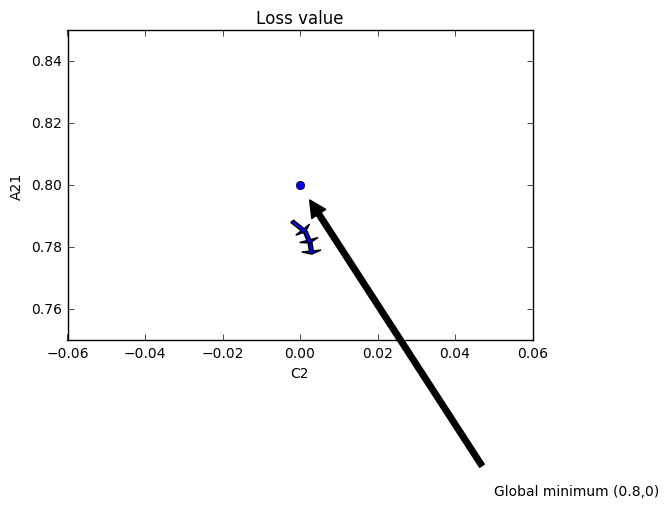

In [206]:
# plot the BP process
ax = plt.axes()
# plt.figure()
for idx in range(1,len(loss_total_values)):
    ax.arrow(float(parameter_values2[idx-1]), parameter_values1[idx-1],\
             float(parameter_values2[idx])-float(parameter_values2[idx-1]), (parameter_values1[idx]-parameter_values1[idx-1]),\
            head_width=0.005, head_length=0.001,length_includes_head=True)


plt.annotate('Global minimum (0.8,0)', xy=(0, 0.8), xytext=(0.05, 0.7),
            arrowprops=dict(facecolor='black', shrink=0.05),)
plt.plot(0,0.8,'bo')
plt.title('Loss value')
plt.xlabel('C2')
plt.ylabel('A21')
plt.show()

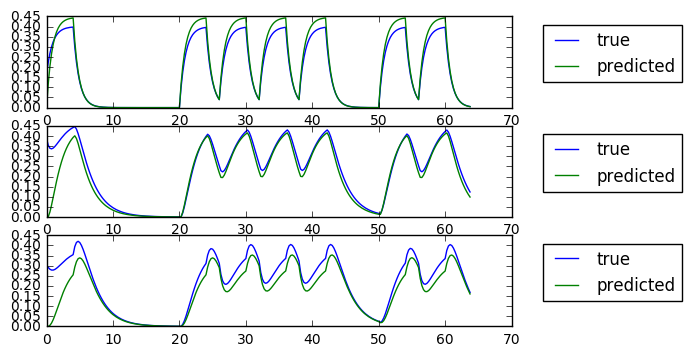

In [207]:
# visulize pridicted x_state and true x_state (after training)
x_predicted=util.forward_pass_x(dr,dh,isess)
n_monitor=256
for n in range(m.n_region):
    plt.subplot(3,1,n+1)
    plt.plot(np.arange(n_monitor)*m.t_delta,x[n,0,:n_monitor].transpose(),label='true')
    plt.plot(np.arange(n_monitor)*m.t_delta,x_predicted[n,0:n_monitor].transpose(),label='predicted')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

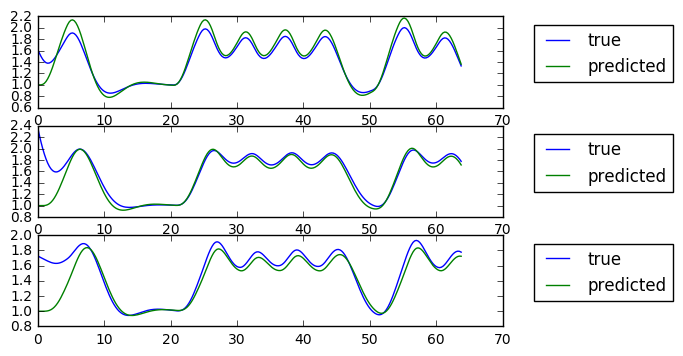

In [208]:
# visulize pridicted h_state and true h_state (before training)
h_predicted=util.forward_pass_h(dr,dh,isess)
n_monitor=256
i_h_state=1
for n in range(m.n_region):
    plt.subplot(3,1,n+1)
    plt.plot(np.arange(n_monitor)*m.t_delta,h[n,i_h_state,0:n_monitor].transpose(),label='true')
    plt.plot(np.arange(n_monitor)*m.t_delta,h_predicted[n][i_h_state,0:n_monitor].transpose(),label='predicted')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

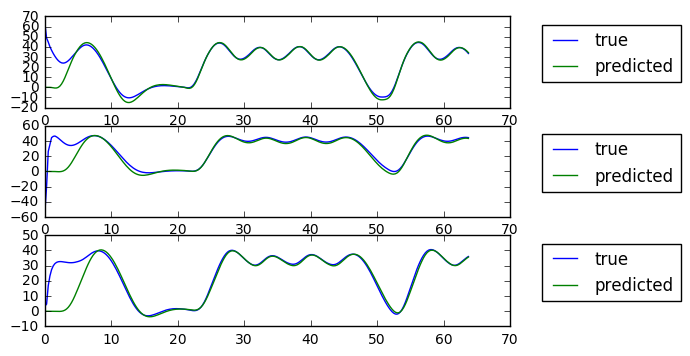

In [209]:
y_predicted=util.forward_pass_y(dr,dh,isess)
n_monitor=256#m.n_time_point
for n in range(m.n_region):
    plt.subplot(3,1,n+1)
    plt.plot(np.arange(n_monitor)*m.t_delta,y[n,0,:n_monitor].transpose(),label='true')
    plt.plot(np.arange(n_monitor)*m.t_delta,y_predicted[n,0:n_monitor].transpose(),label='predicted')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

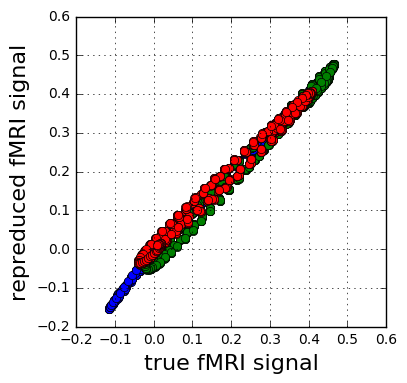

In [217]:
#fig,ax=plt.subplot(111,aspect=1)
#fig,ax=plt.subplots()
fig = plt.figure()
ax = fig.add_subplot(111,aspect=1)
plt.plot(np.squeeze(y[0,0,61:])/100,y_predicted[0,61:]/100,'o')
plt.plot(np.squeeze(y[1,0,61:])/100,y_predicted[1,61:]/100,'o')
plt.plot(np.squeeze(y[2,0,61:])/100,y_predicted[2,61:]/100,'o')

plt.axis([-0.2, 0.6, -0.2, 0.6])
ax.grid(True)
#plt.axis(aspect='equal')

plt.xlabel('true fMRI signal',fontsize=16)
plt.ylabel('repreduced fMRI signal',fontsize=16)
savefig('after_training_noised.png', bbox_inches='tight')

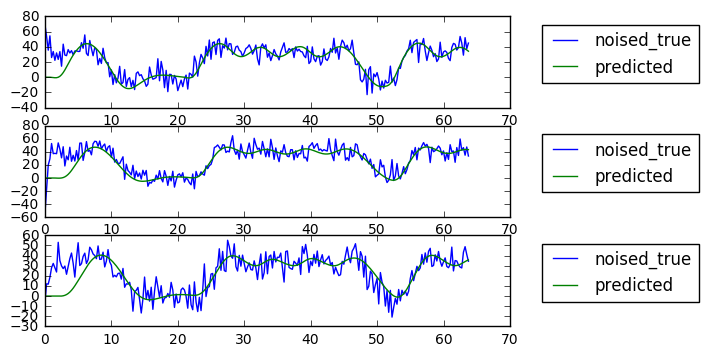

In [211]:
y_predicted=util.forward_pass_y(dr,dh,isess)
n_monitor=256#m.n_time_point
for n in range(m.n_region):
    plt.subplot(3,1,n+1)
    plt.plot(np.arange(n_monitor)*m.t_delta,y_noised[n,0,:n_monitor].transpose(),label='noised_true')
    plt.plot(np.arange(n_monitor)*m.t_delta,y_predicted[n,0:n_monitor].transpose(),label='predicted')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

In [212]:
importlib.reload(DCM_RNN)
util=DCM_RNN.utilities()
parameter_true=s.show_all_variable_value(False)
parameter_trained=util.show_all_variable_value(dr,isess,visFlag=False)
tmp=util.compare_parameters(parameter_trained,parameter_true,visFlag=True,parameter_list=['Wxx','Wxxu_s0','Wxu','hemodynamic_parameters'])

Wxx


set1                        set2                 difference  \
        From_r0   From_r1   From_r2 From_r0 From_r1 From_r2    From_r0   
To_r0  0.738892  0.000036  0.000025    0.75    0.00    0.00  -0.011108   
To_r1  0.193714  0.750324  0.079757    0.20    0.75    0.10  -0.006286   
To_r2  0.041966  0.191364  0.782222    0.10    0.20    0.75  -0.058034   

                           
        From_r1   From_r2  
To_r0  0.000036  0.000025  
To_r1  0.000324 -0.020243  
To_r2 -0.008636  0.032222

Wxxu_s0


set1                        set2                 difference  \
        From_r0   From_r1   From_r2 From_r0 From_r1 From_r2    From_r0   
To_r0  0.000089  0.000037  0.000016     0.0     0.0     0.0   0.000089   
To_r1 -0.000006 -0.000007 -0.000006     0.0     0.0     0.0  -0.000006   
To_r2 -0.000006  0.000005 -0.115477     0.0     0.0    -0.1  -0.000006   

                           
        From_r1   From_r2  
To_r0  0.000037  0.000016  
To_r1 -0.000007 -0.000006  
To_r2  0.000005 -0.015477

Wxu


,set1,set2,difference
,stimuli_0,stimuli_0,stimuli_0
To_r0,0.116405,0.1,0.016405
To_r1,0.000985,0.0,0.000985
To_r2,0.000048,0.0,0.000048


hemodynamic_parameters


alpha        E0         k     gamma       tao  \
set1       region_0  0.325475  0.318659  0.650138  0.410996  0.962980   
           region_1  0.317445  0.361942  0.653429  0.409304  1.019518   
           region_2  0.312890  0.335717  0.642507  0.410146  0.878476   
set2       region_0  0.297512  0.316932  0.692635  0.413096  0.948192   
           region_1  0.313804  0.354622  0.723287  0.409610  0.952512   
           region_2  0.306641  0.312019  0.626602  0.438645  1.017214   
difference region_0  0.027963  0.001727 -0.042496 -0.002100  0.014788   
           region_1  0.003641  0.007320 -0.069858 -0.000305  0.067006   
           region_2  0.006249  0.023698  0.015905 -0.028500 -0.138738   

                          epsilon     V0            TE    r0        theta0  
set1       region_0  4.000000e-01  100.0  3.000000e-02  25.0  4.030000e+01  
           region_1  4.000000e-01  100.0  3.000000e-02  25.0  4.030000e+01  
           region_2  4.000000e-01  100.0  3.000000e-02  25.0  4.030000e+01  
set2       region_0  4.000000e-01  100.0  3.000000e-02  25.0  4.030000e+01  
           region_1  4.000000e-01  100.0  3.000000e-02  25.0  4.030000e+01  
           region_2  4.000000e-01  100.0  3.000000e-02  25.0  4.030000e+01  
difference region_0  5.960464e-09    0.0 -6.705523e-10   0.0 -7.629395e-07  
           region_1  5.960464e-09    0.0 -6.705523e-10   0.0 -7.629395e-07  
           region_2  5.960464e-09    0.0 -6.705523e-10   0.0 -7.629395e-07

In [213]:
#A_hat=(np.array([[0.752, 0.00, 0], [0.202, 0.762, 0.075],[0.035, 0.184, 0.760]])-np.eye(3,3,0))/m.t_delta
A_hat=(isess.run(dr.Wxx)-np.eye(3,3,0))/m.t_delta
A_true=np.array([[-1,0,0],[0.8,-1,0.4],[0.4,0.8,-1]])
acc_A=1-np.sqrt(((A_hat - A_true) ** 2).flatten().mean(axis=-1))
print(A_hat)
print(acc_A)

[[ -1.04443383e+00   1.44925987e-04   1.00375561e-04]
 [  7.74857759e-01  -9.98702049e-01   3.19027007e-01]
 [  1.67863473e-01   7.65457869e-01  -8.71112108e-01]]
0.905215183102


In [215]:
#B_hat=(np.array([[0.0, 0.0, 0], [0.0, 0.0, 0.],[0.0, 0.0, -0.106]]))/m.t_delta
B_hat=isess.run(dr.Wxxu)[0]/m.t_delta
B_true=np.array([[0,0,0],[0,0,0],[0,0,-0.4]])
acc_B=1-np.sqrt(((B_hat - B_true) ** 2).flatten().sum(axis=0))/np.sqrt(((B_true) ** 2).flatten().sum(axis=0))
print(B_hat)
print(acc_B)

[[  3.56670411e-04   1.46093895e-04   6.39581704e-05]
 [ -2.36749911e-05  -2.91416400e-05  -2.30131409e-05]
 [ -2.24398427e-05   2.03464479e-05  -4.61908847e-01]]
0.845224742506


In [216]:
#B_hat=(np.array([0.095, 0.0, 0]))/m.t_delta
C_hat=isess.run(dr.Wxu)/m.t_delta
C_true=np.array([0.4, 0, 0]).reshape(3,1)
acc_C=1-np.sqrt(((C_hat - C_true) ** 2).flatten().sum(axis=0))/np.sqrt(((C_true) ** 2).flatten().sum(axis=0))
print(C_hat)
print(acc_C)

[[  4.65621531e-01]
 [  3.93825024e-03]
 [  1.91275685e-04]]
0.835650301692


In [267]:
np.array([0,2,4])

array([0, 2, 4])

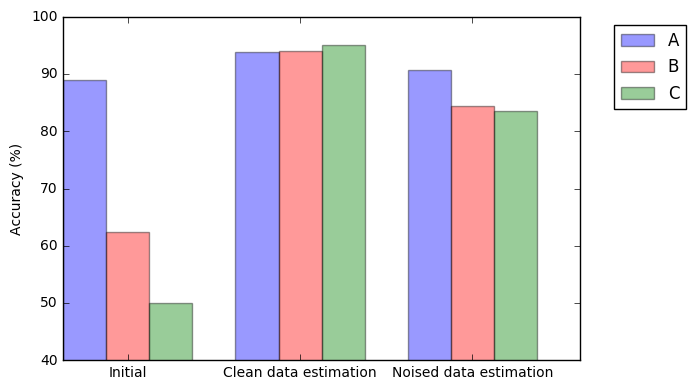

In [274]:
acc_A_list =[88.9, 93.8, 90.7]
acc_B_list =[62.5, 94, 84.5]
acc_C_list =[50, 95, 83.6]
index = np.array([0,2,4])
bar_width=0.5
opacity = 0.4
error_config = {'ecolor': '0.3'}
rects1 = plt.bar(index, acc_A_list, bar_width,
                 alpha=opacity,
                 color='b',
                 error_kw=error_config,
                 label='A')

rects2 = plt.bar(index + bar_width, acc_B_list, bar_width,
                 alpha=opacity,
                 color='r',
                 error_kw=error_config,
                 label='B')

rects3 = plt.bar(index + 2*bar_width, acc_C_list, bar_width,
                 alpha=opacity,
                 color='g',
                 error_kw=error_config,
                 label='C')

#plt.xlabel('Conditions')
plt.ylabel('Accuracy (%)')
#plt.title('Scores by group and gender')
plt.xticks(index + 1.5*bar_width, ('Initial', 'Clean data estimation', 'Noised data estimation'),\
          fontsize=10)
plt.legend()
plt.axis([0, 6, 40, 100])
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
#plt.show()
plt.savefig('estimationAccuracy.png', bbox_inches='tight')